In [3]:
import os
import io
import sys
import time
#
import numpy as np
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
#
import zipfile
#
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms

In [7]:
import torch
import torch.nn as nn
from models.autoencoder_vgg19.vgg19_1 import vgg_normalised_conv1_1, feature_invertor_conv1_1
from models.autoencoder_vgg19.vgg19_2 import vgg_normalised_conv2_1, feature_invertor_conv2_1
from models.autoencoder_vgg19.vgg19_3 import vgg_normalised_conv3_1, feature_invertor_conv3_1
from models.autoencoder_vgg19.vgg19_4 import vgg_normalised_conv4_1, feature_invertor_conv4_1
from models.autoencoder_vgg19.vgg19_5 import vgg_normalised_conv5_1, feature_invertor_conv5_1

class Encoder(nn.Module):

    def __init__(self, depth):
        super(Encoder, self).__init__()

        assert(type(depth).__name__ == 'int' and 1 <= depth <= 5)
        self.depth = depth

        if depth == 1:
            self.model = vgg_normalised_conv1_1.vgg_normalised_conv1_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_1/vgg_normalised_conv1_1.pth"))
        elif depth == 2:
            self.model = vgg_normalised_conv2_1.vgg_normalised_conv2_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_2/vgg_normalised_conv2_1.pth"))
        elif depth == 3:
            self.model = vgg_normalised_conv3_1.vgg_normalised_conv3_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_3/vgg_normalised_conv3_1.pth"))
        elif depth == 4:
            self.model = vgg_normalised_conv4_1.vgg_normalised_conv4_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_4/vgg_normalised_conv4_1.pth"))
        elif depth == 5:
            self.model = vgg_normalised_conv5_1.vgg_normalised_conv5_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_5/vgg_normalised_conv5_1.pth"))


    def forward(self, x):
        out = self.model(x)
        return out


class Decoder(nn.Module):
    def __init__(self, depth):
        super(Decoder, self).__init__()

        assert (type(depth).__name__ == 'int' and 1 <= depth <= 5)
        self.depth = depth

        if depth == 1:
            self.model = feature_invertor_conv1_1.feature_invertor_conv1_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_1/feature_invertor_conv1_1.pth"))
        elif depth == 2:
            self.model = feature_invertor_conv2_1.feature_invertor_conv2_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_2/feature_invertor_conv2_1.pth"))
        elif depth == 3:
            self.model = feature_invertor_conv3_1.feature_invertor_conv3_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_3/feature_invertor_conv3_1.pth"))
        elif depth == 4:
            self.model = feature_invertor_conv4_1.feature_invertor_conv4_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_4/feature_invertor_conv4_1.pth"))
        elif depth == 5:
            self.model = feature_invertor_conv5_1.feature_invertor_conv5_1
            self.model.load_state_dict(torch.load("models/autoencoder_vgg19/vgg19_5/feature_invertor_conv5_1.pth"))

    def forward(self, x):
        out = self.model(x)
        return out

In [12]:
transform1 = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])

denormalize = transforms.Normalize((-(0.485/0.229), -(0.456/0.224), -(0.406/0.225)), ((1/0.229), (1/0.224), (1/0.255))) 

In [13]:
class CustomDataSetImg(Dataset):
    def __init__(self, imagelist, transform):
        super().__init__()
        self.imagepaths = imagelist
        self.transform = transform

    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, index):
        self.imagepath = self.imagepaths[index]
        self.image = Image.open(self.imagepath).convert('RGB')

        self.i = self.transform(self.image)
        return self.i.detach(), self.imagepath

In [25]:
#Código de wct extraído de GitHub del paper
def wct(alpha, cf, sf, s1f=None, beta=None):

    # content image whitening
    cf = cf.double()
    c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
    cfv = cf.view(c_channels, -1)  # c x (h x w)

    c_mean = torch.mean(cfv, 1) # perform mean for each row
    c_mean = c_mean.unsqueeze(1).expand_as(cfv) # add dim and replicate mean on rows
    cfv = cfv - c_mean # subtract mean element-wise

    c_covm = torch.mm(cfv, cfv.t()).div((c_width * c_height) - 1)  # construct covariance matrix
    c_u, c_e, c_v = torch.svd(c_covm, some=False) # singular value decomposition

    k_c = c_channels
    for i in range(c_channels):
        if c_e[i] < 0.00001:
            k_c = i
            break
    c_d = (c_e[0:k_c]).pow(-0.5)

    w_step1 = torch.mm(c_v[:, 0:k_c], torch.diag(c_d))
    w_step2 = torch.mm(w_step1, (c_v[:, 0:k_c].t()))
    whitened = torch.mm(w_step2, cfv)

    # style image coloring
    sf = sf.double()
    _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
    sfv = sf.view(c_channels, -1)

    s_mean = torch.mean(sfv, 1)
    s_mean = s_mean.unsqueeze(1).expand_as(sfv)
    sfv = sfv - s_mean

    s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
    s_u, s_e, s_v = torch.svd(s_covm, some=False)

    s_k = c_channels # same number of channels ad content features
    for i in range(c_channels):
        if s_e[i] < 0.00001:
            s_k = i
            break
    s_d = (s_e[0:s_k]).pow(0.5)

    c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
    c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
    colored = torch.mm(c_step2, whitened)

    cs0_features = colored + s_mean.resize_as_(colored)
    cs0_features = cs0_features.view_as(cf)

    # additional style coloring
    if beta:
        sf = s1f
        sf = sf.double()
        _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
        sfv = sf.view(c_channels, -1)

        s_mean = torch.mean(sfv, 1)
        s_mean = s_mean.unsqueeze(1).expand_as(sfv)
        sfv = sfv - s_mean

        s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
        s_u, s_e, s_v = torch.svd(s_covm, some=False)

        s_k = c_channels
        for i in range(c_channels):
            if s_e[i] < 0.00001:
                s_k = i
                break
        s_d = (s_e[0:s_k]).pow(0.5)

        c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
        c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
        colored = torch.mm(c_step2, whitened)

        cs1_features = colored + s_mean.resize_as_(colored)
        cs1_features = cs1_features.view_as(cf)

        target_features = beta * cs0_features + (1.0 - beta) * cs1_features
    else:
        target_features = cs0_features

    ccsf = alpha * target_features + (1.0 - alpha) * cf
    return ccsf.float().unsqueeze(0)

In [14]:
def wctvgg19(alpha,image, style, encoder,decoder):
    with torch.no_grad(): #Porque wct no admite gradiente
        cf = encoder(image)
        sf = encoder(style)
        result = wct(alpha = alpha, cf = cf, sf = sf)
    return decoder(result) #El [0] es porque wct entrega en formato B x C x (H x W)

In [15]:
for i in range(5, 2-1, -1):
    print (i)

5
4
3
2


In [16]:
styledir = "style"
styleobj = natsorted(os.listdir(styledir))
# #Entonces puedo armar una lista con todas las direcciones
styleArray = []
for i in range(0, len(styleobj)):
   styleArray.append(os.path.join(styledir, styleobj[i]))

In [17]:
styles = CustomDataSetImg(styleArray, transform = transform1)

In [18]:
imagedir = "test"
imageobj = natsorted(os.listdir(imagedir))
# #Entonces puedo armar una lista con todas las direcciones
imageArray = []
for i in range(0, len(imageobj)):
   imageArray.append(os.path.join(imagedir, imageobj[i]))

In [19]:
images = CustomDataSetImg(imageArray, transform = transform1)

In [23]:
def MultilayerST(maxL,minL, image, style, alpha):
    result = image
    for i in range(maxL,minL-1, -1):
        result = torch.squeeze(wctvgg19(alpha, result, style, Encoder(depth = i), Decoder(depth = i)))
        print(result.shape)

    return denormalize(result).detach()

In [26]:
MultilayerST(3,1, images[0][0], styles[0][0], 0.6).shape

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


torch.Size([3, 224, 224])

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


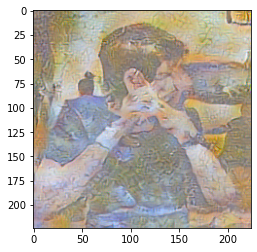

In [37]:
plt.imshow(MultilayerST(maxL = 5,minL = 1,image = images[0][0],style = styles[5][0],alpha = 0.5).permute(1,2,0))